# Topic Modeling Using Russian Troll Tweets
In this script, I show simple topic modeling using Russian troll tweets (https://github.com/fivethirtyeight/russian-troll-tweets).

First, I import the libraries, read the dataset and look at the data:

In [1]:
# import libraries
%matplotlib inline
import os
import re
import glob
import spacy
import random
import pandas as pd
import matplotlib.pyplot as plt
import nltk 

import gensim
from gensim import corpora, models
from gensim.models import LdaModel
from gensim.models import CoherenceModel
import pyLDAvis.gensim
import gensim.corpora as corpora
from gensim.models.wrappers import LdaMallet

from pprint import pprint

import pymorphy2

from IPython.display import HTML

import pyLDAvis
pyLDAvis.enable_notebook()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# read all files and concatenate them in one data frame
all_files = glob.glob('/Users/zhanna.terechshenko/Dropbox/Text-as-Data/russian-troll-tweets-master/*.csv')
df_from_each_file = (pd.read_csv(f,index_col=0,parse_dates=[0]) for f in all_files)
df  = pd.concat(df_from_each_file, ignore_index=True)
print(df.shape)
df.head(5)

/Users/zhanna.terechshenko/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: DtypeWarning: Columns (15,20) have mixed types. Specify dtype option on import or set low_memory=False.
/Users/zhanna.terechshenko/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: DtypeWarning: Columns (10,20) have mixed types. Specify dtype option on import or set low_memory=False.
/Users/zhanna.terechshenko/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.


(2946207, 20)


,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,retweet,account_category,new_june_2018,alt_external_id,tweet_id,article_url,tco1_step1,tco2_step1,tco3_step1
0,DAILYSANFRAN,Police: Airline pilot found passed out in cock...,United States,English,1/2/2017 14:39,1/2/2017 14:39,4577,16782,34960,NaN,local,0,NewsFeed,0,2495567768,815930489311789056,http://twitter.com/2495567768/statuses/8159304...,https://twitter.com/DailySanFran/status/815930...,http://kron4.com/2017/01/02/police-airline-pil...,NaN
1,DAILYSANFRAN,Dashcam video shows man launching himself onto...,United States,English,1/2/2017 15:39,1/2/2017 15:39,4577,16782,34961,NaN,local,0,NewsFeed,0,2495567768,815945595546431488,http://twitter.com/2495567768/statuses/8159455...,https://twitter.com/DailySanFran/status/815945...,http://kron4.com/2017/01/02/dashcam-video-show...,NaN
2,DAILYSANFRAN,Man Arrested For Setting Fire To South SF Medi...,United States,English,1/2/2017 16:19,1/2/2017 16:19,4577,16782,34962,NaN,local,0,NewsFeed,0,2495567768,815955659963432960,http://twitter.com/2495567768/statuses/8159556...,https://twitter.com/DailySanFran/status/815955...,http://sanfrancisco.cbslocal.com/2017/01/02/ma...,NaN
3,DAILYSANFRAN,Practical tips to achieving your New Year's re...,United States,English,1/2/2017 16:29,1/2/2017 16:29,4577,16782,34963,NaN,local,0,NewsFeed,0,2495567768,815958175593730049,http://twitter.com/2495567768/statuses/8159581...,https://twitter.com/DailySanFran/status/815958...,http://abc7news.com/society/practical-tips-to-...,NaN
4,DAILYSANFRAN,Couple disappears during trip to Big Sur https...,United States,English,1/2/2017 16:39,1/2/2017 16:39,4577,16781,34964,NaN,local,0,NewsFeed,0,2495567768,815960697800626176,http://twitter.com/2495567768/statuses/8159606...,https://twitter.com/DailySanFran/status/815960...,http://kron4.com/2017/01/02/couple-disappears-...,NaN


In [3]:
#Check missing values, o
df['content'].isnull().sum()

1

In [4]:
#Remove rows with NA in content
df.dropna(subset = ['content'], inplace = True)

Since there has been a lot of work done on the analysis of metadata (timing and location of tweets), I will focus on texts.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55]), <a list of 56 Text xticklabel objects>)

(array([      0.,  500000., 1000000., 1500000., 2000000., 2500000.]),
 <a list of 6 Text yticklabel objects>)

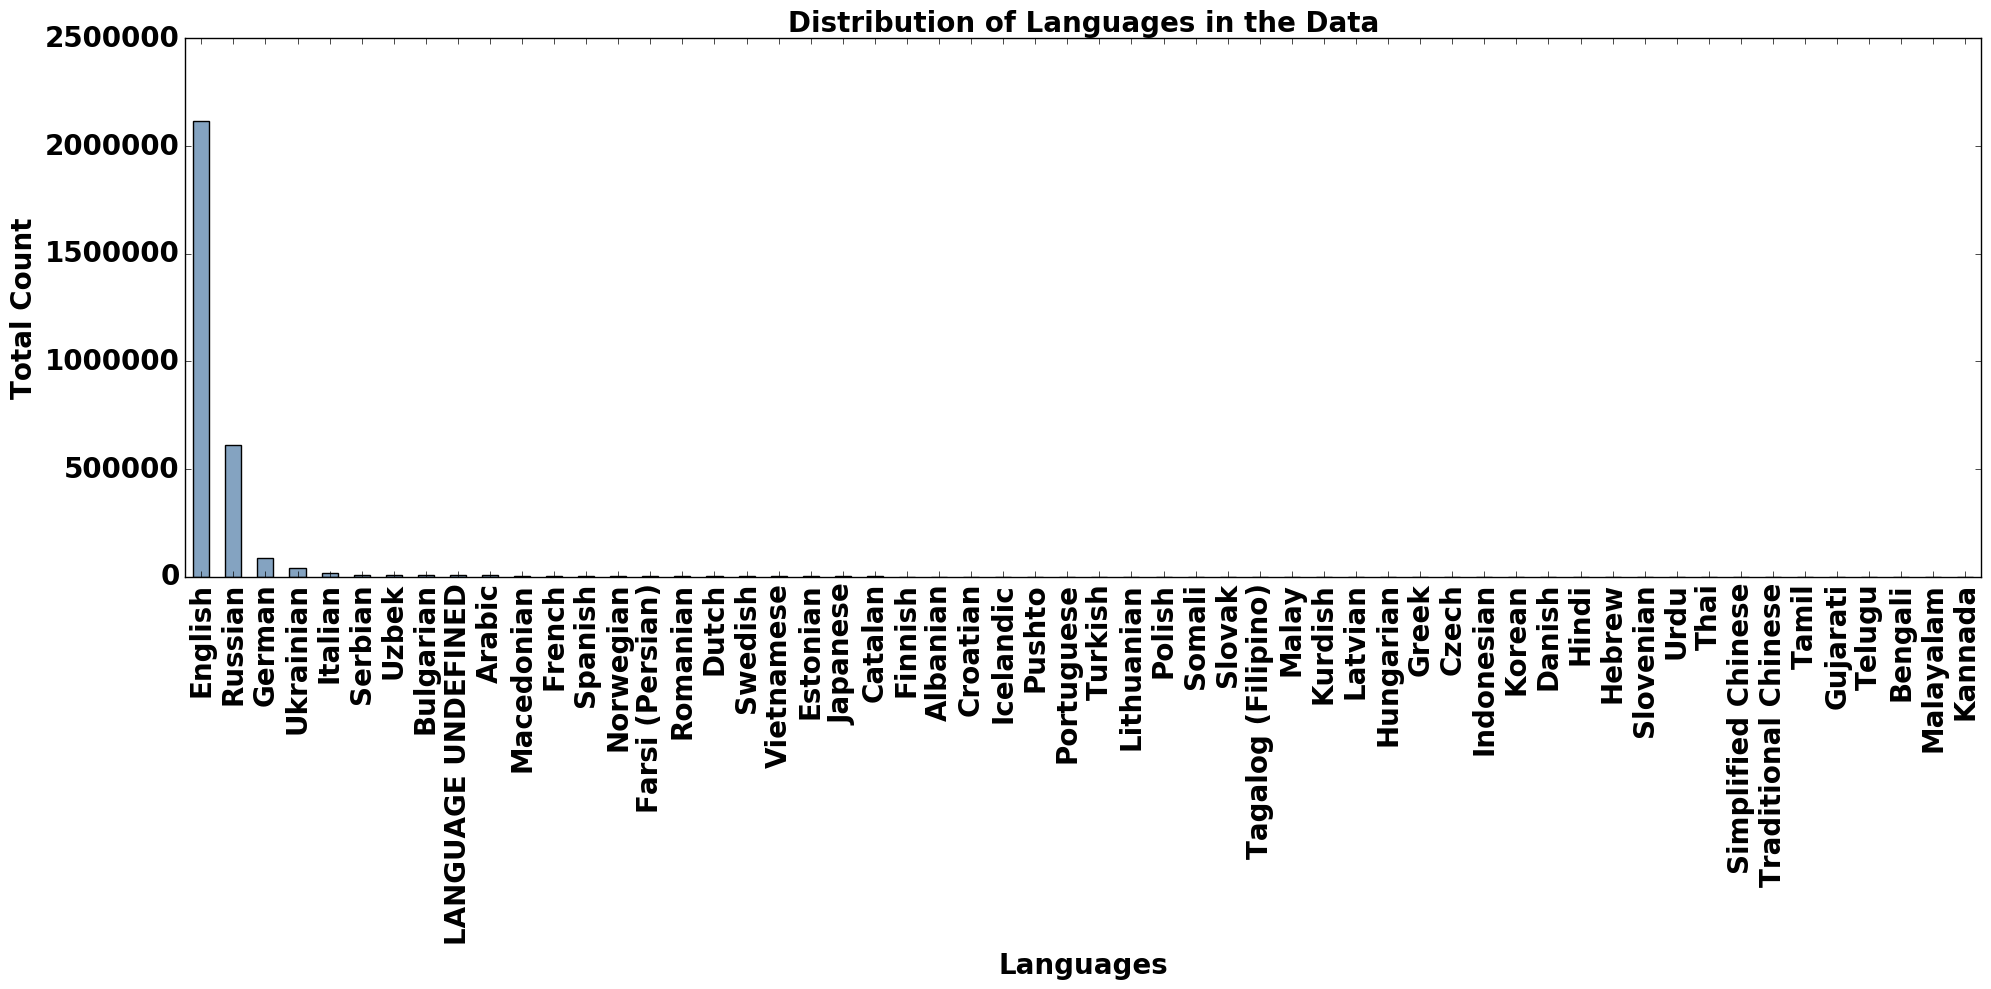

In [5]:
#df['language'].value_counts()
plt.figure(figsize=(20,10))
pd.value_counts(df['language']).plot.bar(color=(0.2, 0.4, 0.6, 0.6))
plt.xticks(fontsize=20, fontweight='bold',rotation=90)
plt.yticks(fontsize=20, fontweight='bold')
plt.xlabel('Languages',fontsize=20, fontweight='bold')
plt.ylabel('Total Count',fontsize=20, fontweight='bold')
plt.title('Distribution of Languages in the Data',fontsize=20, fontweight='bold')
plt.tight_layout()

In [6]:
# Choose English language
df_en = df[df['language']=='English']
# Get random sample of the data
random.seed(927)
df_subset = df_en.sample(10000)
tweets_txt = df_subset.content

tweets_txt.head(10)

941971     '@truthrocker  Look in the mirror and whispere...
209359     RT dannyreb: That's a good question. It has to...
1519077    I will never be using @UberEATS or @Uber again...
2516813    Man Buys Eggs At Grocery Store, Then One Of Th...
405947     Just caught myself thinking that when stay alo...
2814518    Neil Diamond coming to Cleveland in May https:...
2445711    Taiwan probes water park fire as tally of inju...
1830085    Vey's shootout goal lifts Canucks to 4-3 win o...
1449531    'Huntsman' sequel misfires; 'Jungle Book' reig...
850818     #GOPDebate You know that  Well, I think the Re...
Name: content, dtype: object

In [7]:
#empty list to store the cleaned data
clean_tweets = []

#define elements we need to remove
stopwords = nltk.corpus.stopwords.words('english') # I use NLTK stopwords here 
url = re.compile(r'http\S+') # urls
non_alpha_numer= re.compile('[\W_]+') #characters that are not letters or numbers
hashtag = re.compile(r'#[^\s$\n]+') # hashtags
handle = re.compile(r'@[^\s$\n]+') # handles
extra_space = re.compile(r' +') # spaces 

#Load Spacy English model, keeping only tagger and parser components needed for lemmatization
nlp = spacy.load('en', disable=['ner'])

# Preprocesing function
def preprocess(txt):
    
    for tweet in txt:
              
        # remove url, hashtag, handle
        new_tweet = url.sub(' ', tweet)
        new_tweet = hashtag.sub(' ', new_tweet)
        new_tweet = handle.sub(' ', new_tweet)
        
        # lemmatize
        
        # Parse the sentence using the loaded 'en' model object `nlp`
        doc = nlp(new_tweet)
        # Extract the lemma for each token and join
        new_tweet = " ".join([token.lemma_ if token.lemma_ != '-PRON-' else token.lower_ for token in doc])
           
    
        # remove stopwords and words with less than 3 characters
        new_tweet = [w for w in new_tweet.split(' ') if w not in stopwords and len(w)>2]
        new_tweet = ' '.join(new_tweet)
    
        # remove everything that is not a letter or number character
        new_tweet = non_alpha_numer.sub(repl=' ', string=new_tweet)
        new_tweet = extra_space.sub(repl=' ', string=new_tweet)
        
        # remove words with less than 3 characters
        new_tweet = [w for w in new_tweet.split(' ') if len(w)>2]
        new_tweet = ' '.join(new_tweet)

    
        clean_tweets.append(new_tweet)

In [8]:
preprocess(tweets_txt)
clean_tweets[:10]

['look mirror whisper time criminal change anything',
 'dannyreb good question secure bunker muslim brotherhood make',
 'never use bad customer service ever get',
 'man buys eggs grocery store one cracks open home see pink',
 'catch think stay alone thing focus fat',
 'neil diamond come cleveland may',
 'taiwan probe water park fire tally injure put 498',
 'vey shootout goal lift canucks win red wings',
 'huntsman sequel misfire jungle book reign',
 'know well think republican party populist party']

In [9]:
# Create Dictionary
dataset = [tweet.split() for tweet in clean_tweets]
dictionary = corpora.Dictionary(dataset)
 
# Create Corpus
corpus = [dictionary.doc2bow(tweet) for tweet in dataset]
 

# Train the model on the corpus.
lda_5 = models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=5,
                                            random_state=100, 
                                           update_every=1, #Determines how often the model parameters should be updated
                                           chunksize=500, #the number of documents to be used in each training chunk
                                           passes=10, # the total number of training passes
                                           alpha='auto',
                                           per_word_topics=True)


In [10]:
# Visualization
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_5, corpus, dictionary, n_jobs=1)


/Users/zhanna.terechshenko/anaconda/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      28.969673        1       1  0.273192 -0.169069
1      27.688143        1       2 -0.236360 -0.215258
3      15.701726        1       3 -0.011021  0.142764
2      14.659722        1       4 -0.008186  0.120886
0      12.980732        1       5 -0.017625  0.120677, topic_info=      Category        Freq           Term       Total  loglift  logprob
term                                                                   
12898  Default  666.000000          trump  666.000000  30.0000  30.0000
13489  Default  351.000000            get  351.000000  29.0000  29.0000
9668   Default  336.000000            new  336.000000  28.0000  28.0000
8009   Default  329.000000            say  329.000000  27.0000  27.0000
12856  Default  261.000000            man  261.000000  26.0000  26.0000
9931   Default  247.000000           make  247.000000  25.0000  25.0000
12217  Default  251.000000         police  251.000000  24.0000  24.0000
10391  Default  149.000000          break  149.000000  23.0000  23.0000
8615   Default  214.000000           good  214.000000  22.0000  22.0000
10879  Default  212.000000           like  212.000000  21.0000  21.0000
10010  Default  127.000000          state  127.000000  20.0000  20.0000
9767   Default  191.000000           year  191.000000  19.0000  19.0000
7896   Default  186.000000          black  186.000000  18.0000  18.0000
4539   Default  183.000000          video  183.000000  17.0000  17.0000
3085   Default  181.000000           kill  181.000000  16.0000  16.0000
2923   Default  177.000000            one  177.000000  15.0000  15.0000
8179   Default  170.000000           call  170.000000  14.0000  14.0000
5766   Default  160.000000           need  160.000000  13.0000  13.0000
6038   Default  157.000000          woman  157.000000  12.0000  12.0000
262    Default  151.000000            day  151.000000  11.0000  11.0000
13291  Default  148.000000           want  148.000000  10.0000  10.0000
1636   Default  147.000000           know  147.000000   9.0000   9.0000
10129  Default   99.000000        america   99.000000   8.0000   8.0000
10074  Default  142.000000           time  142.000000   7.0000   7.0000
11779  Default  141.000000           look  141.000000   6.0000   6.0000
1431   Default  145.000000        hillary  145.000000   5.0000   5.0000
11663  Default  143.000000        clinton  143.000000   4.0000   4.0000
68     Default  146.000000            via  146.000000   3.0000   3.0000
2477   Default  137.000000          would  137.000000   2.0000   2.0000
2452   Default  136.000000        workout  136.000000   1.0000   1.0000
...        ...         ...            ...         ...      ...      ...
5391    Topic5   54.543858          thank   55.223103   2.0293  -5.1012
8253    Topic5   54.354713            lie   55.037460   2.0292  -5.1047
13092   Topic5   53.225739          fight   53.904720   2.0290  -5.1257
9666    Topic5   50.278275          force   50.963062   2.0282  -5.1826
11965   Topic5   45.242996           much   45.924717   2.0267  -5.2882
7592    Topic5   45.348324           feel   46.032787   2.0267  -5.2858
9992    Topic5   42.502560         happen   43.185261   2.0258  -5.3506
1616    Topic5   41.771469            ban   42.452415   2.0255  -5.3680
3659    Topic5   39.670906           word   40.354858   2.0246  -5.4196
6851    Topic5   38.537960          judge   39.224926   2.0240  -5.4486
754     Topic5   37.470051          press   38.165035   2.0233  -5.4767
1046    Topic5   36.333004     california   37.015392   2.0231  -5.5075
140     Topic5   35.482830           drug   36.160862   2.0228  -5.5312
5870    Topic5   35.557434         george   36.253525   2.0223  -5.5291
13743   Topic5   34.278328          close   34.961376   2.0220  -5.5657
453     Topic5   33.198132       question   33.880093   2.0214  -5.5977
3109    Topic5   31.328979         always   32.0131

In [11]:
# Let's try 3 topics

lda_3 = models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=3,
                                            random_state=100, 
                                           update_every=1, #Determines how often the model parameters should be updated
                                           chunksize=500, #the number of documents to be used in each training chunk
                                           passes=10, # the total number of training passes
                                           alpha='auto',
                                           per_word_topics=True)

pyLDAvis.gensim.prepare(lda_3, corpus, dictionary, n_jobs=1)


/Users/zhanna.terechshenko/anaconda/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      42.747463        1       1 -0.239689 -0.067490
2      33.202591        1       2  0.184952 -0.152601
0      24.049950        1       3  0.054737  0.220092, topic_info=      Category        Freq       Term       Total  loglift  logprob
term                                                               
12898  Default  628.000000      trump  628.000000  30.0000  30.0000
9668   Default  317.000000        new  317.000000  29.0000  29.0000
12856  Default  230.000000        man  230.000000  28.0000  28.0000
12217  Default  221.000000     police  221.000000  27.0000  27.0000
8009   Default  310.000000        say  310.000000  26.0000  26.0000
13489  Default  346.000000        get  346.000000  25.0000  25.0000
3085   Default  160.000000       kill  160.000000  24.0000  24.0000
52     Default  205.000000      obama  205.000000  23.0000  23.0000
9931   Default  244.000000       make  244.000000  22.0000  22.0000
4539   Default  172.000000      video  172.000000  21.0000  21.0000
10459  Default  215.000000     people  215.000000  20.0000  20.0000
8615   Default  211.000000       good  211.000000  19.0000  19.0000
10879  Default  209.000000       like  209.000000  18.0000  18.0000
10391  Default  159.000000      break  159.000000  17.0000  17.0000
7896   Default  182.000000      black  182.000000  16.0000  16.0000
1431   Default  137.000000    hillary  137.000000  15.0000  15.0000
10010  Default  136.000000      state  136.000000  14.0000  14.0000
11663  Default  135.000000    clinton  135.000000  13.0000  13.0000
9767   Default  173.000000       year  173.000000  12.0000  12.0000
2923   Default  173.000000        one  173.000000  11.0000  11.0000
10595  Default  100.000000       show  100.000000  10.0000  10.0000
5008   Default  124.000000  president  124.000000   9.0000   9.0000
5766   Default  157.000000       need  157.000000   8.0000   8.0000
6744   Default  118.000000       lose  118.000000   7.0000   7.0000
262    Default  149.000000        day  149.000000   6.0000   6.0000
11664  Default   87.000000       give   87.000000   5.0000   5.0000
13291  Default  146.000000       want  146.000000   4.0000   4.0000
1636   Default  145.000000       know  145.000000   3.0000   3.0000
6120   Default   83.000000      shoot   83.000000   2.0000   2.0000
10074  Default  140.000000       time  140.000000   1.0000   1.0000
...        ...         ...        ...         ...      ...      ...
3762    Topic3   81.324303        way   82.075264   1.4158  -5.3184
6689    Topic3   62.416847     charge   63.065594   1.4147  -5.5830
13004   Topic3   61.611336        cop   62.283485   1.4142  -5.5960
11796   Topic3   59.718643        hit   60.389187   1.4139  -5.6272
11721   Topic3   51.745781      crash   52.391411   1.4126  -5.7705
3291    Topic3   52.122505       dead   52.775440   1.4126  -5.7633
13092   Topic3   54.635468      fight   55.329914   1.4124  -5.7162
10083   Topic3   48.232494        car   48.853199   1.4123  -5.8408
6912    Topic3   51.964954   official   52.639133   1.4121  -5.7663
9666    Topic3   51.609432      force   52.310246   1.4115  -5.7732
10940   Topic3   47.024887        die   47.690220   1.4110  -5.8662
12466   Topic3   45.108704      death   45.757874   1.4107  -5.9078
11356   Topic3   43.302822    suspect   43.938667   1.4105  -5.9487
13779   Topic3   47.247337        pay   47.963921   1.4100  -5.8615
1885    Topic3   46.587601       poll   47.306690   1.4097  -5.8755
9444    Topic3   40.274986   shooting   40.908676   1.4094  -6.0212
5797    Topic3   42.141941       head   42.811684   1.4093  -5.9758
1880    Topic3   44.281658       hold   44.994179   1.4091  -5.9263
9992    Topic3   43.623238     happen   44.326405   1.4090  -5.9413
8583    Topic3   43.893570      money   44.613098   1.4088  -5.9351
10595   Topic3   99.015739       show  100.645622   1.4087  -5.1216
7112    Topic3 

In [12]:
# Perplexity 
print('\nPerplexity: ', lda_3.log_perplexity(corpus))

# Coherence Score - cow coherent are the topics?
coherence_model_lda = CoherenceModel(lda_3, texts = dataset, dictionary=dictionary, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.929067590682758

Coherence Score:  -7.281155358455345


In [13]:
path_to_mallet_binary = "/Users/zhanna.terechshenko/Mallet/bin/mallet"
lda_mallet= LdaMallet(path_to_mallet_binary, corpus=corpus, num_topics=3, id2word=dictionary)

In [14]:
# Show Topics
pprint(lda_mallet.show_topics(formatted=False))

[(0,
  [('trump', 0.03730940824631073),
   ('people', 0.01166838260528509),
   ('obama', 0.0113742216992695),
   ('break', 0.008922880815806247),
   ('clinton', 0.008138451733098004),
   ('time', 0.007942344462420944),
   ('state', 0.0076481835564053535),
   ('hillary', 0.007452076285728294),
   ('white', 0.006912781291366377),
   ('president', 0.006814727656027847)]),
 (1,
  [('make', 0.012651346676550532),
   ('amp', 0.010872251050160613),
   ('year', 0.010822831727205337),
   ('call', 0.009785025945144552),
   ('day', 0.008598962194217939),
   ('report', 0.005880899431677786),
   ('work', 0.005534964170990858),
   ('today', 0.00528786755621448),
   ('fire', 0.005040770941438102),
   ('watch', 0.005040770941438102)]),
 (2,
  [('man', 0.015266428536477956),
   ('police', 0.014043157019131966),
   ('good', 0.011792337427215345),
   ('kill', 0.00993296472084944),
   ('video', 0.009443656113911044),
   ('workout', 0.009052209228360327),
   ('woman', 0.008905416646278808),
   ('black', 0.

In [15]:
converted_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet)
pyLDAvis.gensim.prepare(converted_model, corpus, dictionary, n_jobs=1)


/Users/zhanna.terechshenko/anaconda/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      33.375806        1       1 -0.000790 -0.000171
1      33.356243        1       2  0.000543 -0.000598
2      33.267951        1       3  0.000247  0.000768, topic_info=      Category      Freq           Term     Total  loglift  logprob
term                                                               
5732   Default  5.000000      elections  5.000000  30.0000  30.0000
525    Default  4.000000    convenience  4.000000  29.0000  29.0000
9451   Default  5.000000      biography  5.000000  28.0000  28.0000
10617  Default  5.000000          dress  5.000000  27.0000  27.0000
13587  Default  4.000000  excommunicate  4.000000  26.0000  26.0000
12357  Default  4.000000            yas  4.000000  25.0000  25.0000
9285   Default  5.000000       observer  5.000000  24.0000  24.0000
12572  Default  4.000000           ruth  4.000000  23.0000  23.0000
9239   Default  5.000000       disorder  5.000000  22.0000  22.0000
13243  Default  4.000000       hometown  4.000000  21.0000  21.0000
6337   Default  5.000000           lame  5.000000  20.0000  20.0000
11838  Default  4.000000         cereal  4.000000  19.0000  19.0000
3810   Default  5.000000        skrmhlz  5.000000  18.0000  18.0000
3325   Default  4.000000            tas  4.000000  17.0000  17.0000
4513   Default  5.000000        phantom  5.000000  16.0000  16.0000
12383  Default  5.000000      unearthed  5.000000  15.0000  15.0000
12136  Default  5.000000          patty  5.000000  14.0000  14.0000
9455   Default  4.000000           alex  4.000000  13.0000  13.0000
11119  Default  5.000000          ready  5.000000  12.0000  12.0000
8169   Default  4.000000         emblem  4.000000  11.0000  11.0000
12885  Default  5.000000          allah  5.000000  10.0000  10.0000
5258   Default  4.000000     collinrugg  4.000000   9.0000   9.0000
10657  Default  5.000000          sheep  5.000000   8.0000   8.0000
1276   Default  5.000000        quoting  5.000000   7.0000   7.0000
1021   Default  4.000000      worldwide  4.000000   6.0000   6.0000
9667   Default  5.000000         nature  5.000000   5.0000   5.0000
707    Default  5.000000          stack  5.000000   4.0000   4.0000
645    Default  5.000000         excuse  5.000000   3.0000   3.0000
6404   Default  5.000000       legalise  5.000000   2.0000   2.0000
2004   Default  4.000000       macleans  4.000000   1.0000   1.0000
...        ...       ...            ...       ...      ...      ...
11645   Topic3  2.027068        midwest  5.163386   0.1656  -9.3348
3903    Topic3  2.013942     okeechobee  5.132376   0.1651  -9.3412
9402    Topic3  2.089134        airport  5.325239   0.1649  -9.3046
12383   Topic3  2.002313      unearthed  5.107666   0.1641  -9.3470
5502    Topic3  1.955051            cdc  4.984466   0.1647  -9.3709
7939    Topic3  1.982592           luce  5.060039   0.1636  -9.3569
4372    Topic3  2.108256       arsonist  5.412866   0.1577  -9.2955
12228   Topic3  2.025935            mtn  5.191425   0.1596  -9.3353
11850   Topic3  2.040739      residence  5.258248   0.1541  -9.3280
8830    Topic3  2.066319       upcoming  5.349558   0.1493  -9.3156
3565    Topic3  2.037240        signing  5.254415   0.1531  -9.3297
5707    Topic3  2.064680         thanks  5.402295   0.1387  -9.3164
4630    Topic3  2.047731       abruptly  5.344133   0.1413  -9.3246
2201    Topic3  2.030097      convicted  5.271452   0.1464  -9.3333
12895   Topic3  2.087408     highlights  5.531936   0.1260  -9.3054
10251   Topic3  2.031035           sick  5.282824   0.1447  -9.3328
10801   Topic3  2.045662          offer  5.360397   0.1373  -9.3256
25      Topic3  2.028819          paris  5.275596   0.1449  -9.3339
9209    Topic3  2.044932         galaxy  5.397111   0.1301  -9.3260
13547   Topic3  2.045594       behaving  5.420788   0.1260  -9.3257
2372    Topic3  2.072703         kittel  5.671403   0.0940  -9.3125
8914    Topic3 

In [16]:
# Coherence Score
coherence_lda_mallet = CoherenceModel(lda_mallet, texts = dataset, dictionary=dictionary, coherence='c_v')
coherence_lda_mallet = coherence_lda_mallet.get_coherence()
print('\nCoherence Score: ', coherence_lda_mallet)


Coherence Score:  0.37092364692640084


This coherence score looks much better.

As a Russian native-speaker, I am curious about how topics from the tweets in Russian look. So, I decided to run a model on the tweets in Russian and see how it looks

In [17]:
df_rus = df[df['language']=='Russian']
df_subset = df_rus.sample(100)
tweets_txt = df_subset.content
tweets_txt.head(10)

2505607    Что если Жора Крыжовников и Квартет И сплетутс...
2716010                      #Казань https://t.co/sR8UiEFA4m
2290987    Депутат ЗС Новосибирской области  @ska700 пред...
245878     Болельщики сборных России и Молдавии сыграют т...
417968     Veritas & aequitas: парадоксы современной проп...
1485140    Источник: Встреча Лаврова и Керри состоится 3 ...
1787539    Полиция попросит суд арестовать лидера секты "...
2116963    В метро в Нью-Йорке ездят вагоны, оформленные ...
807282     Артист из России Николай Диденко получил «Грэм...
1534483    Писатель года: Пелевин и Прилепин пропустили в...
Name: content, dtype: object

For the preprocessing of the tweets in Russian (lemmatization), I use pymorphy2 package (also can be used for Ukrainian language)

In [18]:
morph = pymorphy2.MorphAnalyzer()

#empty list to store the cleaned data
clean_tweets_rus = []

#define elements we need to remove
stopwords = nltk.corpus.stopwords.words('russian') # I use NLTK stopwords here 
url = re.compile(r'http\S+') # urls
non_alpha_numer= re.compile('[\W_]+') #characters that are not letters or numbers
hashtag = re.compile(r'#[^\s$\n]+') # hashtags
handle = re.compile(r'@[^\s$\n]+') # handles
extra_space = re.compile(r' +') # spaces 

# Preprocesing function
def preprocess(txt):
    
    for tweet in txt:
              
        # remove url, hashtag, handle
        new_tweet = url.sub(' ', tweet)
        new_tweet = hashtag.sub(' ', new_tweet)
        new_tweet = handle.sub(' ', new_tweet)
        
        # lemmatize
        
        # Parse the sentence using the loaded 'en' model object `nlp`
        doc = nlp(new_tweet)
        # Extract the lemma for each token and join
        new_tweet = " ".join(pymorphy2.MorphAnalyzer().parse(str(word))[0].normal_form for word in new_tweet.split())
           
    
        # remove stopwords and words with less than 3 characters
        new_tweet = [w for w in new_tweet.split(' ') if w not in stopwords and len(w)>2]
        new_tweet = ' '.join(new_tweet)
    
        # remove everything that is not a letter or number character
        new_tweet = non_alpha_numer.sub(repl=' ', string=new_tweet)
        new_tweet = extra_space.sub(repl=' ', string=new_tweet)
        
        # remove words with less than 3 characters
        new_tweet = [w for w in new_tweet.split(' ') if len(w)>2]
        new_tweet = ' '.join(new_tweet)

    
        clean_tweets_rus.append(new_tweet)

In [19]:
preprocess(tweets_txt)
clean_tweets_rus[:10]

['жор крыжовниковый квартет сплестись порыв снять новогодний фильм специя фонд кино приятного',
 '',
 'депутат новосибирский область представитель целое положительно оценивать кампания',
 'болельщик сборный россия молдавия сыграть товарищеский матч кишинёв',
 'veritas aequitas парадокс современный пропаганда',
 'источник встреча лавров керри состояться декабрь',
 'полиция попросить суд арестовать лидер секта бог кузи',
 'метро нью йорк ездить вагоны оформить свастика вроде просто рекламировать сериал выглядеть натуальный',
 'артист россия николай диденко получить грэмми хороший хоровой пение',
 'писатель года пелевин прилепин пропустить вперёд дарья донцов']

In [20]:
# Create Dictionary
dataset = [tweet.split() for tweet in clean_tweets_rus]
dictionary = corpora.Dictionary(dataset)
 
# Create Corpus
corpus = [dictionary.doc2bow(tweet) for tweet in dataset]
 
# Train the model on the corpus.
lda_mallet= LdaMallet(path_to_mallet_binary, corpus=corpus, num_topics=3, id2word=dictionary)

In [21]:
converted_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet)
pyLDAvis.gensim.prepare(converted_model, corpus, dictionary, n_jobs=1)


/Users/zhanna.terechshenko/anaconda/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
0      33.643166        1       1 -0.000442  0.000663
2      33.392832        1       2 -0.000369 -0.000704
1      32.964002        1       3  0.000811  0.000041, topic_info=     Category      Freq                Term     Total  loglift  logprob
term                                                                   
608   Default  1.000000              ретвит  1.000000  30.0000  30.0000
487   Default  1.000000          18метровый  1.000000  29.0000  29.0000
483   Default  1.000000             конкурс  1.000000  28.0000  28.0000
250   Default  1.000000               перми  1.000000  27.0000  27.0000
308   Default  1.000000               matiz  1.000000  26.0000  26.0000
305   Default  1.000000              flickr  1.000000  25.0000  25.0000
443   Default  1.000000          вооружение  1.000000  24.0000  24.0000
267   Default  1.000000       военнопленный  1.000000  23.0000  23.0000
492   Default  1.000000         современный  1.000000  22.0000  22.0000
475   Default  1.000000               times  1.000000  21.0000  21.0000
409   Default  1.000000             русский  1.000000  20.0000  20.0000
501   Default  1.000000                 дтп  1.000000  19.0000  19.0000
420   Default  1.000000          отсутствие  1.000000  18.0000  18.0000
504   Default  1.000000              делать  1.000000  17.0000  17.0000
560   Default  1.000000            поднятие  1.000000  16.0000  16.0000
408   Default  1.000000                метр  1.000000  15.0000  15.0000
219   Default  1.000000                 330  1.000000  14.0000  14.0000
426   Default  1.000000  высокопоставленный  1.000000  13.0000  13.0000
132   Default  1.000000          определить  1.000000  12.0000  12.0000
326   Default  1.000000              группа  1.000000  11.0000  11.0000
8     Default  1.000000              любить  1.000000  10.0000  10.0000
614   Default  1.000000            крымский  1.000000   9.0000   9.0000
48    Default  1.000000             попытка  1.000000   8.0000   8.0000
29    Default  1.000000          молодёжный  1.000000   7.0000   7.0000
328   Default  1.000000            кампания  1.000000   6.0000   6.0000
495   Default  1.000000               морда  1.000000   5.0000   5.0000
165   Default  1.000000                 при  1.000000   4.0000   4.0000
91    Default  1.000000             бышовец  1.000000   3.0000   3.0000
50    Default  1.000000           поступить  1.000000   2.0000   2.0000
7     Default  1.000000               видео  1.000000   1.0000   1.0000
...       ...       ...                 ...       ...      ...      ...
39     Topic3  0.445361        товарищеский  1.199579   0.1189  -6.3429
168    Topic3  0.469319             косплей  1.265276   0.1180  -6.2905
409    Topic3  0.442126             русский  1.192634   0.1174  -6.3502
325    Topic3  0.428640             граница  1.157128   0.1167  -6.3812
616    Topic3  0.456276               запад  1.232718   0.1159  -6.3187
139    Topic3  0.448469          новогодний  1.212912   0.1148  -6.3360
209    Topic3  0.441860        великолепным  1.197785   0.1125  -6.3508
25     Topic3  0.414372     ответственность  1.125094   0.1109  -6.4150
157    Topic3  0.430243      переохлаждения  1.168535   0.1106  -6.3774
93     Topic3  0.454524        приостановка  1.235523   0.1098  -6.3225
270    Topic3  0.450522             девушка  1.228104   0.1069  -6.3314
6      Topic3  0.433035        опровергнуть  1.181369   0.1061  -6.3710
58     Topic3  0.453833               френд  1.239696   0.1049  -6.3241
589    Topic3  0.439652                киев  1.201144   0.1047  -6.3558
229    Topic3  0.444196          рахманинов  1.214186   0.1042  -6.3455
564    Topic3  0.455513            оформить  1.248114   0.1018  -6.3204
336    Topic3  0.459464              кремль  1.260832   0.1003  -6.3117
22     Topic3  0.451766             четверо  1.237869   0.1018  -6.3286
559    Topic3  

In [22]:
# Show Topics
pprint(lda_mallet.show_topics(formatted=False))


[(0,
  [('россия', 0.03731343283582089),
   ('сша', 0.022388059701492536),
   ('российский', 0.014925373134328358),
   ('сборный', 0.014925373134328358),
   ('фильм', 0.011194029850746268),
   ('пиздец', 0.011194029850746268),
   ('ребёнок', 0.011194029850746268),
   ('весь', 0.011194029850746268),
   ('сирия', 0.011194029850746268),
   ('украина', 0.011194029850746268)]),
 (1,
  [('матч', 0.012244897959183673),
   ('назвать', 0.012244897959183673),
   ('фото', 0.012244897959183673),
   ('мир', 0.012244897959183673),
   ('отказаться', 0.00816326530612245),
   ('сыграть', 0.00816326530612245),
   ('рубль', 0.00816326530612245),
   ('постпред', 0.00816326530612245),
   ('санкция', 0.00816326530612245),
   ('ато', 0.00816326530612245)]),
 (2,
  [('год', 0.023529411764705882),
   ('метро', 0.01568627450980392),
   ('получить', 0.011764705882352941),
   ('турция', 0.011764705882352941),
   ('2016', 0.011764705882352941),
   ('хороший', 0.011764705882352941),
   ('выбор', 0.00784313725490196

In [23]:
# Coherence Score
coherence_lda_mallet = CoherenceModel(lda_mallet, texts = dataset, dictionary=dictionary, coherence='c_v')
coherence_lda_mallet = coherence_lda_mallet.get_coherence()
print('\nCoherence Score: ', coherence_lda_mallet)


Coherence Score:  0.7612931015822372


In [24]:
It seems that the model was able to identify pretty coherent topics within Russian texts.

To be continued

SyntaxError: invalid syntax (<ipython-input-24-00f85500df93>, line 1)